In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from scipy import stats

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amssymb}')
import matplotlib.pyplot as plt

old_stdout = sys.__stdout__

In [2]:
# dataset
from torch.utils.data import Dataset, DataLoader

class Data(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = self.x[idx]
        label = self.y[idx]
        image = image.reshape(784)
        return image, label

def get_dataloader(x, y, batch_size, num_worker, shuffle):
    '''Use PyTorch Dataset to enable multiprocessing to prepare data.
    '''
    dataset = Data(x, y)
    
    init_fun = np.random.seed()
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_worker,
        worker_init_fn=init_fun
    )
    return dataloader

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
tfd = tfp.distributions

from datetime import datetime
def print_log(*args):
    print("[{}]".format(datetime.now()), *args)
    sys.stdout.flush()

class VariationalAutoEncoder:
    def __init__(self, x_dim, z_dim, lr=0.001, kl_weight=1.0):
        
        # 'z_dim, activation, loss' can be tuned
        
        # reset the default graph otherwise the variable initialization will get
        # slower because all models create the variables and operations in the
        # same graph
        tf.reset_default_graph()
        
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.lr = lr
        self.kl_weight = kl_weight
        
        with tf.compat.v1.variable_scope('placeholder'):
            x_shape = [None] + [self.x_dim]
            self.x = tf.placeholder(
                tf.float32, 
                shape=x_shape)
        
        with tf.compat.v1.variable_scope('networks'):
            self.recog = keras.Sequential(
                [
                    layers.Dense(100, activation='relu'),
                    layers.Dense(self.z_dim*2, activation='relu'),
                ]
            )
            self.gen = keras.Sequential(
                [
                    layers.Dense(100, activation='relu'),
                    layers.Dense(self.x_dim, activation='relu'),
                ]
            )
        
        with tf.compat.v1.variable_scope('z'):
            self.p_z = tfd.Normal(
                loc=0.,
                scale=1.,
                name='p_z_dist')
            
            self.z_param = self.recog(self.x)
            self.z_mean = self.z_param[:, :self.z_dim]
            self.z_std = tf.math.softplus(self.z_param[:, self.z_dim:])

            self.q_z = tfd.Normal(
                loc=self.z_mean,
                scale=self.z_std,
                name='q_z_dist')
            
            self.z = self.q_z.sample()
            
        self.re_x = self.gen(self.z)
        
        with tf.compat.v1.variable_scope('training_loss'):
            self.rec_error = keras.losses.mean_squared_error(self.x, self.re_x)
            self.kl_loss = tf.reduce_mean(tfd.kl_divergence(self.q_z, self.p_z, name='KL'), axis=-1)
            self.nelbo = self.rec_error + self.kl_weight * self.kl_loss
            self.ave_nelbo = tf.reduce_mean(self.nelbo)
        
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=self.lr)
        self.train_step = self.optimizer.minimize(self.ave_nelbo)
        
        # sample from prior
        self.z_from_prior = self.p_z.sample()
        self.x_sample = self.gen(self.z_from_prior)
        
    # initialization
    def init_session(self):
        # Initializing the variables
        init = tf.global_variables_initializer()

        # launch a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = False #True
        self.sess = tf.Session(config=config)

        self.sess.run(init)
        
    def train(self, tr_loader, no_epochs=500, te_loader=None):
        costs = []
        rec_error = []
        kl_loss = []
        
        for epoch_idx in range(no_epochs):
            epoch_cost = 0.
            epoch_lik_cost = 0.
            epoch_kl_cost = 0.
            for batch_idx, tr_batch in enumerate(tr_loader):
                tr_x, _, = tr_batch
                _, cost, kl, rec = self.sess.run(
                    [
                        self.train_step,
                        self.ave_nelbo,
                        self.kl_loss,
                        self.rec_error
                    ],
                    feed_dict={
                        self.x: tr_x
                    }
                )
                
                epoch_cost += cost
                epoch_lik_cost += np.mean(rec)
                epoch_kl_cost += np.mean(kl)
                
                costs.append(cost)
                rec_error.append(np.mean(rec))
                kl_loss.append(np.mean(kl))
                
            epoch_idx += 1
            epoch_cost /= epoch_idx
            epoch_lik_cost /= epoch_idx
            epoch_kl_cost /= epoch_idx
            
            print_log("Epoch:", '%04d' % (epoch_idx), 
                "total cost=", 
                "{:.9f}".format(epoch_cost), 
                "log-likelihood term=", 
                "{:.9f}".format(epoch_lik_cost), 
                "kl/regluarization term=", 
                "{:.9f}".format(epoch_cost - epoch_lik_cost))
            
        return costs, epoch_lik_cost, epoch_kl_cost

In [4]:
mini_batchsize = 64
no_epochs = 50
lr = 0.001
z_dim = 10

# data
(x_train, y_train), (x_test, y_test) = \
    tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
y_train = np.squeeze(y_train)
x_test = x_test.astype('float32')
y_test = np.squeeze(y_test)
x_train /= 255
x_test /= 255

mnist_tr_loader = get_dataloader(x_train, y_train, mini_batchsize, 4, True)

# model
vae = VariationalAutoEncoder(x_dim=784, z_dim=z_dim, lr=lr)
vae.init_session()

# train
vae.train(mnist_tr_loader, no_epochs=no_epochs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
[2021-06-05 17:44:43.165083] Epoch: 0002 total cost= 86.518294632 log-likelihood term= 64.310820505 kl/regluarization term= 22.207474127
[2021-06-05 17:44:47.038463] Epoch: 0003 total cost= 41.999615222 log-likelihood term= 31.961637134 kl/regluarization term= 10.037978088
[2021-06-05 17:44:50.988228] Epoch: 0004 total cost= 27.986521870 log-likelihood term= 21.306938014 kl/regluarization term= 6.679583856
[2021-06-05 17:44:54.885333] Epoch: 0005 total cost= 20.987773813 log-likelihood term= 15.979468402 kl/regluarization term= 5.008305411
[2021-06-05 17:44:58.795692] Epoch: 0006 total cost= 16.790315138 log-likelihood term= 12.784674775 kl/regluarization term= 4.005640363
[2021-06-05 17:45:02.813752] Epoch: 0007 total cost= 13.990387380 log-likelihood term= 10.652728521 kl/regluarization term= 3.337658859
[2021-06-05 17:45:06.785798] Epoch: 0008 total cost= 11.992053274 log-likelihood term= 9.131286625 kl

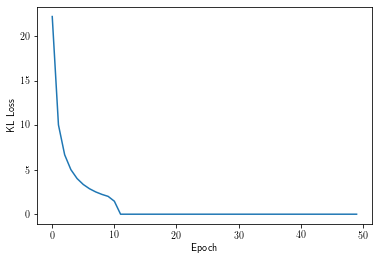

In [15]:
kl_loss = [22.207474127, 10.037978088, 6.679583856, 5.008305411, 4.005640363, 3.337658859, 2.860766649, 2.503097939, 2.224949975, 2.002437756, 1.459572689, 0.000002890, 0.000003404, 0.000003857, 0.000002597, 0.000000944, 0.000007252, 0.000007084, 0.000000559, 0.000016509, 0.000002158, 0.000000577, 0.000011787, 0.000005866, -0.000000000, 0.000004585, 0.000002955, 0.000002077, 0.000000023, 0.000006148, 0.000001790, 0.000000336, 0.000006204, 0.000002660, 0.000001369, 0.000001115, 0.000000091, 0.000005388, 0.000000029, 0.000000238, 0.000000366, 0.000005611, 0.000000494, 0.000000220, 0.000000257, 0.000000179, 0.000009933, 0.000000322, 0.000003292, 0.000000014]

fig = plt.Figure()
ax = fig.subplots(1,1)
ax.plot(kl_loss)
ax.set_xlabel('Epoch')
ax.set_ylabel('KL Loss')
fig

In [12]:
# reconstruct a test image
x_te = x_test[0]
x_te = x_te.reshape(784)
re_x = vae.sess.run([vae.re_x], feed_dict={vae.x: [x_te]})[0][0]

fig = plt.Figure()
axes = fig.subplots(nrows=1, ncols=2)
axes[0].imshow(x_te.reshape(28,28))
axes[1].imshow(re_x.reshape(28,28))

fig

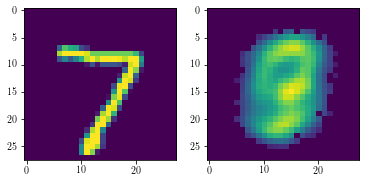